# Cox Proportional Hazards

* In contrast to Kaplan-Meier, Cox Proportional Hazards can be used for multi-variate analysis.

* Similar to Kaplan-Meier, Cox Proportional Hazards can be used to plot survival probability curves but the way it is done differs mathematically. The result is referred to as adjusted survival probability curves because you adjust for other covariates.

## The Cox Proportional Hazards Equation
* Whereas Kaplan-Meier is used to estimate the probability of survival, Cox Proportional Hazards is used to estimate the hazard ratio. The hazard ratio represents the difference in hazard that exists between two individuals (or groups). The hazard is essentially the inverse of survival, or the probability of failure. The fact that Kaplan-Meier estimates the probability of survival whereas Cox Proportional Hazards estimates a hazard ratio is not a concern because as long as you have one, you can calculate the other. The Lifelines library makes this easy to do.

* The Cox Proportional Hazards equation states that the hazard ratio is the product of two terms: the baseline hazard and the partial hazard.

* The baseline hazard is simply a baseline. It's the hazard that exists when each variable is set to a specific value. For example:

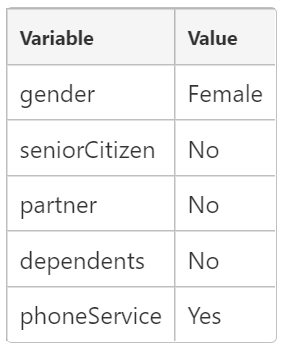

* The partial hazard represents the change in the hazard that occurs when the value for a variable is different from the baseline. At any given time, zero or more variables can contain a value different from the baseline. As seen in the equation below, the resulting change in the hazard is a linear combination of the parameters / variables.

* If every variable were set to its corresponding baseline value, then the partial hazard would equal 1 (since e^0 = 1) and the hazard ratio would equal the baseline hazard.

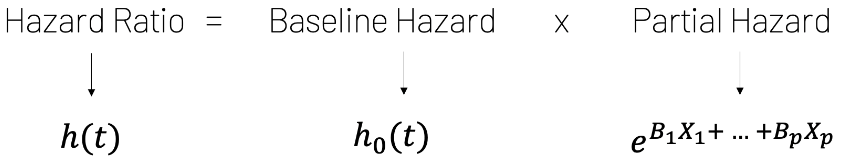

## The Proportional Hazards Assumption
* A subtle but critical element of the Cox Proportional Hazard equation is that the baseline hazard is a function of time t, but not the parameters, whereas the partial hazard is a function of the parameters, but not time. This underpins what is referred to as the proportional hazard assumption.

* The proportional hazard assumption states that in the context of a Cox Proportional Hazard model, the hazard ratio between two groups is proportional over time. This assumption is implicit in the equation above because the lack of t in the partial hazard means that the partial hazard changes the hazard ratio by some factor, independent of time.

#### Setup

In [ ]:
! pip install lifelines

In [3]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np

from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [4]:
! wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

--2022-08-03 21:36:37--  https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘Telco-Customer-Churn.csv’

Telco-Customer-Chur 100%[===================>] 947.71K  --.-KB/s    in 0.05s   

2022-08-03 21:36:37 (19.8 MB/s) - ‘Telco-Customer-Churn.csv’ saved [970457/970457]



1. Read the data
2. Filter to internet subscribers with a month-to-month contract
3. Convert Churn column to a boolean

In [5]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

# To keep the analysis focused, let's just filter to internet subscribers with a month-to-month contract
df = df[df['Contract'] == 'Month-to-month']

df = df[df['InternetService'] != 'No']

# Convert Churn column to a boolean
df['Churn'] = df['Churn'].replace(to_replace=['No', 'Yes'], value=[0, 1])

print('Data Shape : ', df.shape)
df.head()

Data Shape :  (3351, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
